In [3]:
#install.packages(c("lmtest", "sandwich",'car'))
install.packages('quantreg')
library('lmtest') 
library('sandwich')
library('car')
library('quantreg')

also installing the dependencies 'SparseM', 'MatrixModels'




  There is a binary version available but the source version is later:
         binary source needs_compilation
quantreg   5.85   5.86              TRUE

  Binaries will be installed
package 'SparseM' successfully unpacked and MD5 sums checked
package 'MatrixModels' successfully unpacked and MD5 sums checked
package 'quantreg' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'quantreg'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\jancv\.conda\envs\r_env\Lib\R\library\00LOCK\quantreg\doc\rq.pdf to C:\Users\jancv\.conda\envs\r_env\Lib\R\library\quantreg\doc\rq.pdf: Permission denied"Warning message:
"restored 'quantreg'"


The downloaded binary packages are in
	C:\Users\jancv\AppData\Local\Temp\RtmpMzvlch\downloaded_packages


ERROR: Error in library("quantreg"): there is no package called 'quantreg'


First, we generated data in line with the instructions. We decided to include 33 observations to study the behaviour of the estimates using a border value of validity. We believe that this decision will make the estimates interesting.

In [2]:
set.seed(150)
m<-33
data <- matrix(nrow=m,ncol=6)
colnames(data) <- c('price','milage','years_old','convertible','luxury_brand','error')
data[,'milage'] <- rnorm(m,mean=1000,sd=300)
data[,'years_old'] <- sample(c(seq(2,15,1)),m,replace=TRUE)
data[,'convertible'] <- rbinom(m,1,0.5)
data[,'luxury_brand'] <- rbinom(m,1,0.5)
data[,'error'] <- rnorm(m,mean=0,sd=15**(0.5))
data[,'price'] <- 1000 - 0.0005*(data[,'milage']**2) - 5*(data[,'years_old'])+50*(data[,'convertible']) + 100*(data[,'luxury_brand']) + data[,'error']
data <- as.data.frame(data)

### 1.

After simulating the data, we found 4 values to be negative. This, of course, does not make any sense and therefore, these observations were dropped leaving us with a total of 29 data points.

In [6]:
summary(data[,'price'])
sd(data[,'price'])
data <- subset(data,price>=0)
summary(data[,'price'])
sd(data[,'price'])
nrow(data)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -439.4   262.1   473.1   452.9   639.0  1103.1 

[1] 359.768

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.42  363.05  522.09  539.85  731.80 1103.12 

[1] 281.5622

[1] 29

Further, we present the density of the prices as well as the histogram. Based on these statistics, we can notice that the distribution is pretty symmetric. Perhaps, a little bit skewed to the right since the median is lower than mean. Lastly, the standard deviation declined significantly by eliminating the negative observations.

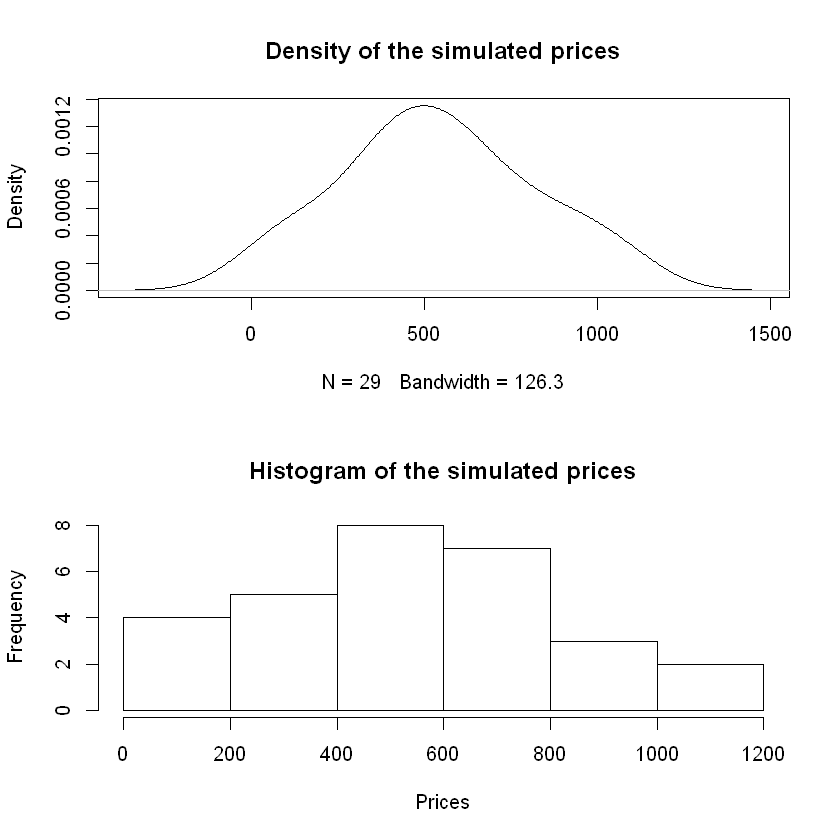

In [24]:
par(mfrow=c(2,1))
plot(density(data[,'price']), main = "Density of the simulated prices")
hist(data[,'price'],main = "Histogram of the simulated prices", xlab="Prices")

### 2.

We estimated the following regression model.

$$\begin{equation*}
price_i = \alpha_0 + \alpha_{1}*milage_i + \alpha * years\_old_i + 50*convertible_i + 100*luxury\_brand_i + \epsilon_i
\end{equation*}$$

In [54]:
summary(model1 <- lm(price ~ milage + years_old + convertible + luxury_brand, data))


Call:
lm(formula = price ~ milage + years_old + convertible + luxury_brand, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-92.004 -27.464   9.348  29.185  76.682 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1279.69375   47.29723  27.056  < 2e-16 ***
milage         -0.84037    0.03969 -21.172  < 2e-16 ***
years_old      -1.61701    2.99570  -0.540    0.594    
convertible     8.90708   20.68242   0.431    0.671    
luxury_brand  107.31408   22.16095   4.842  6.2e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 51.23 on 24 degrees of freedom
Multiple R-squared:  0.9716,	Adjusted R-squared:  0.9669 
F-statistic: 205.4 on 4 and 24 DF,  p-value: < 2.2e-16


First of all, we can see that the R-squared as well as the adjusted one are both really high. This is understandably driven by having artificial data. Normally, this could be a sign of overfitting the model, which might be solved by dividing the sample into training and testing sets.$$\space$$
Nevertheless, we have two insignifacant variables and two significant ones together with the interception. All of the slopes are as expected, but the gradients are distinct. Most evident is the alpha_1, where our prior was -0.0005. This is caused by a false specification of our model since we only assume a normal term of milage and not the squared one, which was used to simulate the data. This problem can be tested using a so-called Ramsey Regression Equation Specification Error Test (RESET) that tests for a non-linear relationship of the regressors in explaining the dependent variable. Further, we also test for the presence of heteroscesasticity by a Breusch-Pagan test.

In [55]:
reset(model1)
bptest(model1)


	RESET test

data:  model1
RESET = 302.18, df1 = 2, df2 = 22, p-value < 2.2e-16



	studentized Breusch-Pagan test

data:  model1
BP = 10.836, df = 4, p-value = 0.02847


In the case of the RESET test, we strongly reject the null-hypothesis meaning that we suffer from a misspecification of our model. This makes sense since the squared term ought to be included.$$\space$$
Regarding the BP-test, we also reject the null-hypothesis leaving our model with variance of the residuals dependent on the explanatory variable(s).

### 3.

Now, we have the following specification

$$\begin{equation*}
price_i = \alpha_0 + \alpha_{1}*milage_{i}^2 + \alpha * years\_old_i + 50*convertible_i + 100*luxury\_brand_i + \epsilon_i
\end{equation*}$$

In [53]:
summary(model2 <- lm(price ~ I(milage*milage) + years_old + convertible + luxury_brand, data))


Call:
lm(formula = price ~ I(milage * milage) + years_old + convertible + 
    luxury_brand, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3422 -1.4784 -0.3514  2.2482  5.8169 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         9.966e+02  2.635e+00  378.28   <2e-16 ***
I(milage * milage) -5.002e-04  1.471e-06 -339.94   <2e-16 ***
years_old          -4.896e+00  1.874e-01  -26.13   <2e-16 ***
convertible         5.122e+01  1.364e+00   37.56   <2e-16 ***
luxury_brand        1.018e+02  1.418e+00   71.75   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.275 on 24 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9999 
F-statistic: 5.174e+04 on 4 and 24 DF,  p-value: < 2.2e-16


This time, the model yields better results. Since we have the true specification, we explain almost all of the variability of the regressand by the regressors. These are all significant having the expected signs. To test this formally, we apply the linear hypothesis test.

In [65]:
linearHypothesis(model2,c("I(milage * milage)=-0.0005"))
linearHypothesis(model2,c("years_old=-5"))
linearHypothesis(model2,c("convertible=50"))
linearHypothesis(model2,c("luxury_brand=100"))

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
25,257.5326,NA,NA,NA,NA
24,257.3737,1,0.1588839,0.01481586,0.9041339


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
25,260.6503,NA,NA,NA,NA
24,257.3737,1,3.276595,0.3055412,0.5855414


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
25,266.0092,NA,NA,NA,NA
24,257.3737,1,8.635466,0.805254,0.3784412


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
25,273.9141,NA,NA,NA,NA
24,257.3737,1,16.54043,1.542389,0.2262625


The null-hypothesis is always that the values are equal. All the p-values are, however, high and we can never reject it. Therefore, this finding supports the prior, which is logical.

### 4.

In this problem, we generate the data using a product of the error term and milage. If we were to estimate the model as in 3, heteroscedasticity would occur since the overall errors would be a function of the milage. The negative observations are not dropped since we would not have many left.

In [96]:
data[,'price_2'] <- 1000 - 0.0005*(data[,'milage']**2) - 5*(data[,'years_old'])+50*(data[,'convertible']) + 100*(data[,'luxury_brand']) + (data[,'milage'])*data[,'error']

In [97]:
summary(model3 <- lm(price_2 ~ I(milage*milage) + years_old + convertible + luxury_brand, data))


Call:
lm(formula = price_2 ~ I(milage * milage) + years_old + convertible + 
    luxury_brand, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5339.0 -1083.2  -432.2  1789.8  5175.3 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)        -2.043e+03  2.246e+03  -0.910   0.3720  
I(milage * milage) -9.013e-04  1.254e-03  -0.719   0.4793  
years_old           1.140e+02  1.597e+02   0.714   0.4821  
convertible         2.238e+02  1.163e+03   0.192   0.8490  
luxury_brand        2.149e+03  1.209e+03   1.777   0.0882 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2792 on 24 degrees of freedom
Multiple R-squared:  0.1687,	Adjusted R-squared:  0.0301 
F-statistic: 1.217 on 4 and 24 DF,  p-value: 0.3296


To check for the issue, we can use the Breusch-Pagan test. Based on the p-value being equal to 0.09686, we are on the border of rejecting the null-hypothesis. This is a bit surprising because we explicitly introduced the form of heteroscedasticity. Perhaps, the low number of observations together with the variability of the simulated errors cause this marginal behaviour. We also present a scatter plotof the variable milage^2 and residuals from the model, where we expect the changing variance.


	studentized Breusch-Pagan test

data:  model3
BP = 7.8596, df = 4, p-value = 0.09686


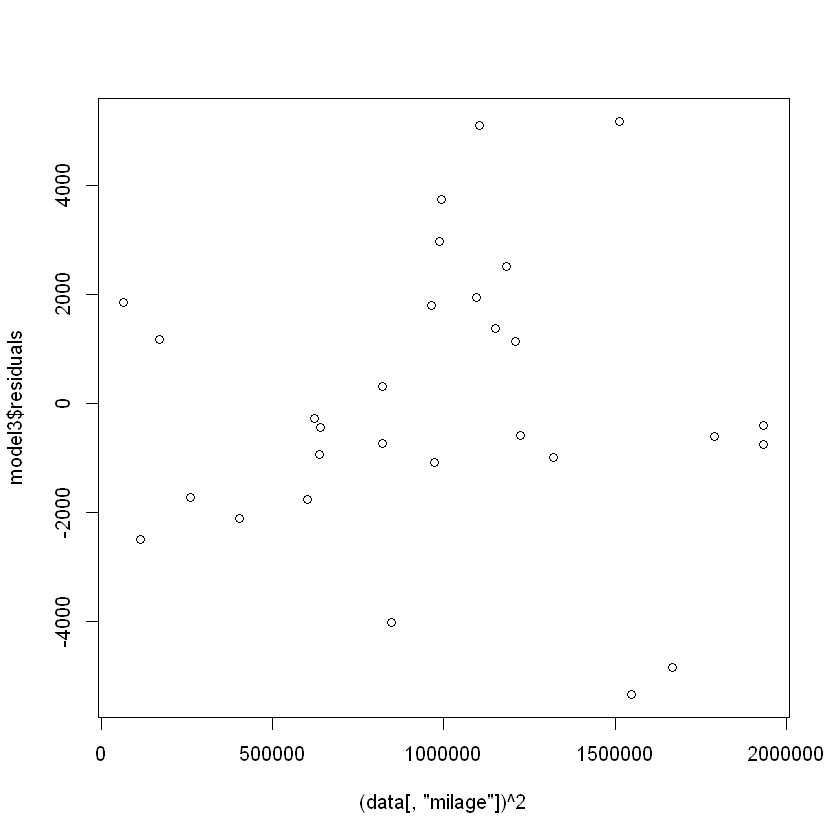

In [99]:
bptest(model3)
plot((data[,'milage'])^2,model3$residuals)

in the case we know the exact form of heteroscedasticity, we can apply it in a method called weighted least squares, where we divide the model by the known form of heteroscedasticity.

In [103]:
w <- (1/data$milage)**2
model3.wls <- lm(price_2 ~ I(milage*milage) + years_old + convertible + luxury_brand, weights = w, data=data)
summary(model3.wls)


Call:
lm(formula = price_2 ~ I(milage * milage) + years_old + convertible + 
    luxury_brand, data = data, weights = w)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-5.5517 -1.3918 -0.2291  2.3106  5.2932 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)        -1.685e+03  1.824e+03  -0.924   0.3647  
I(milage * milage) -7.474e-04  1.130e-03  -0.661   0.5148  
years_old           2.796e+01  1.296e+02   0.216   0.8310  
convertible         1.950e+03  8.325e+02   2.343   0.0278 *
luxury_brand        1.667e+03  1.338e+03   1.246   0.2249  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.043 on 24 degrees of freedom
Multiple R-squared:  0.288,	Adjusted R-squared:  0.1693 
F-statistic: 2.427 on 4 and 24 DF,  p-value: 0.07564


In [101]:
bptest(model3.wls)


	studentized Breusch-Pagan test

data:  model3.wls
BP = 7.8596, df = 4, p-value = 0.09686


### 5.

In [4]:
options(repr.plot.width=6, repr.plot.height=6)
plot(summary(rq(price ~I(milage*milage) + years_old + convertible + luxury_brand, data=data, tau=seq(from=0.05, to=0.95, by=0.05))))

ERROR: Error in rq(price ~ I(milage * milage) + years_old + convertible + luxury_brand, : could not find function "rq"
